In [ ]:
# Assignment
# Part 1: Figure 1 shows a schematic of the robot with a set of coordinate systems following the Denavit-Hartenberg convention. 
# The dimensions given in the schematic are indicative and you might need to revisit them in PART 5 of this assignment, in 
# order to better represent the actual robot that you will work with.


In [1]:
import math
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
sym.init_printing()

![alt text](Part1_default_config.png "Title")

![alt text](axis_colours.png "Title")

![alt text](references_used.jpg "Title")

In [113]:
# DH - parameters explanation:
'''
th_i    --> Angle between x_{i-1} and x_{i} measured in a plane normal to z_{i-1}
a_i     --> Distance between the axes z_{i-1} and z_{i}, and is measured along the axis x{i}
d_i     --> d is the perpendicular distance from o_{i-1} to the intersection of 
            x_{i} with z_{i-1}, measured along the z_{i-1} axis.
alpha_i --> Angle between the axes z_{i-1} and z_{i}, measured in a plane normal to x_{i}
'''

# Function definitions
def get_norm_vector(x1, x2, x3):
    # Assuming v is your vector
    v = np.array([x1, x2, x3])  # Replace with your vector elements

    # Calculate the magnitude (or norm) of the vector
    magnitude = np.linalg.norm(v)

    # Normalize the vector
    v_normalized = v / magnitude

    return v_normalized

# Rotations
def rot_x_sym(angle):
    # Angle is in radians.
    R = [[1, 0, 0] , [0, sym.cos(angle), -sym.sin(angle)] , [0, sym.sin(angle), sym.cos(angle)]]
    return R

def rot_y_sym(angle):
    # Angle is in radians.
    R = [[sym.cos(angle), 0, sym.sin(angle)] , [0, 1, 0] , [-sym.sin(angle), 0, sym.cos(angle)]]
    return R

def rot_z_sym(angle):
    # Angle is in radians.
    R = [[sym.cos(angle), -sym.sin(angle), 0] , [sym.sin(angle), sym.cos(angle), 0] , [0, 0, 1]]
    return R

def rot_x(angle):
    # Angle is in radians.
    R = [[1, 0, 0] , [0, math.cos(angle), -math.sin(angle)] , [0, math.sin(angle), math.cos(angle)]]
    return R

def rot_y(angle):
    # Angle is in radians.
    R = [[math.cos(angle), 0, math.sin(angle)] , [0, 1, 0] , [-math.sin(angle), 0, math.cos(angle)]]
    return R

def rot_z(angle):
    # Angle is in radians.
    R = [[math.cos(angle), -math.sin(angle), 0] , [math.sin(angle), math.cos(angle), 0] , [0, 0, 1]]
    return R

# Translations
def trans_x(distance):
    d = [distance, 0, 0]
    return d

def trans_y(distance):
    d = [0, distance, 0]
    return d

def trans_z(distance):
    d = [0, 0, distance]
    return d

# Homogeneous Functions
def get_H(R,d):
    H = [[R[0][0], R[0][1], R[0][2], d[0]],
         [R[1][0], R[1][1], R[1][2], d[1]],
         [R[2][0], R[2][1], R[2][2], d[2]],
         [0, 0, 0, 1]]
    return H

def get_R_d_from_H(H):
    R = [[H[0][0:3]],
         [H[1][0:3]],
         [H[2][0:3]]]
    d = [H[0][3], H[1][3], H[2][3]]
    return R, d

def get_A(theta, d, a, alpha):
    R0 = [[1,0,0],[0,1,0],[0,0,1]] # Identity matrix
    A = np.array(get_H(rot_z_sym(theta), [0,0,0])) @ np.array(get_H(R0, trans_z(d))) @\
    np.array(get_H(R0, trans_x(a))) @ np.array(get_H(rot_x_sym(alpha), [0,0,0]))
    return A

def skew(v):
    M = np.array([[0, -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]])
    return M

def T04_FK(th11, th22, th33, th44):
    TT4_FK = np.array([[1.0*math.cos(th11)*math.cos(th22 + th33 + th44), -1.0*math.sin(th22 + th33 + th44)*math.cos(th11), 1.0*math.sin(th11),
    (0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.cos(th11)],
    [1.0*math.sin(th11)*math.cos(th22 + th33 + th44), -1.0*math.sin(th11)*math.sin(th22 + th33 + th44), -1.0*math.cos(th11), (0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.sin(th11)],
    [1.0*math.sin(th22 + th33 + th44), 1.0*math.cos(th22 + th33 + th44), 0, 0.093*math.sin(th22) + 0.093*math.sin(th22 + th33) + 0.05*math.sin(th22 + th33 + th44) + 0.05],
     [0, 0, 0, 1.00000000000000]])
    return TT4_FK

def get_Ji(z_i_1, o_i_1, o_n, joint_type):
    if joint_type == 1:
        Ji = np.concatenate((sym.simplify(np.cross(z_i_1, o_n - o_i_1)), z_i_1), axis = 0)
        #Ji = [sym.simplify(np.cross(z_i_1, o_n - o_i_1)), z_i_1]
    elif joint_type == 0:
        Ji = np.concatenate((z_i_1, [0, 0, 0]), axis = 0)

    return Ji

def get_J4(th11, th22, th33, th44):
  J4 = np.array([[-(0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.sin(th11),
    (-0.093*math.sin(th22) - 0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.cos(th11), (-0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.cos(th11), -0.05*math.sin(th22 + th33 + th44)*math.cos(th11)],
  [(0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.cos(th11),
    (-0.093*math.sin(th22) - 0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.sin(th11),
    (-0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.sin(th11),
    -0.05*math.sin(th11)*math.sin(th22 + th33 + th44)],
  [0, 0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44),
    0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44),
    0.05*math.cos(th22 + th33 + th44)],
  [0, 1.0*math.sin(th11), 1.0*math.sin(th11), 1.0*math.sin(th11)],
  [0, -1.0*math.cos(th11), -1.0*math.cos(th11), -1.0*math.cos(th11)],
  [1, 0, 0, 0]])
  return J4

def get_quintic_coeff(q0,v0,ac0,q1,v1,ac1,t0,tf, time_steps):
    
    t = np.linspace(t0, tf, time_steps+1)
    
    M = np.array([
        [1, t0, t0 ** 2, t0 ** 3, t0 ** 4, t0 ** 5],
        [0, 1, 2*t0, 3*t0 ** 2, 4*t0 ** 3, 5*t0 ** 4],
        [0, 0, 2, 6*t0, 12*t0 ** 2, 20*t0 ** 3],
        [1, tf, tf ** 2, tf ** 3, tf ** 4, tf ** 5],
        [0, 1, 2 * tf, 3*tf ** 2, 4*tf ** 3, 5*tf ** 4],
        [0, 0, 2, 6*tf, 12*tf**2, 20*tf**3]])
    
    #print('M: \n', M)
    b= np.transpose([q0, v0, ac0, q1, v1, ac1])
    #print('b: \n', b)
    a = np.matmul(np.linalg.pinv(M), b)
    a = np.round(a, decimals=8)
    #print('a: \n', a)

    # Use of it
    q_d = a[0] + a[1] *t +a[2] *t ** 2 + a[3] *t ** 3 +a[4]*t ** 4 + a[5] *t ** 5 # position trajectory
    q_dot_d = a[1] + 2 * a[2] * t + 3 *a[3] * t ** 2 + 4 * a[4] * t ** 3 + 5 * a[5] * t ** 4 #  velocity trajectory
    q_ddot_d = 2 * a[2] + 6 * a[3] * t + 12 * a[4] * t ** 2 + 20 * a[5] * t ** 3 #  acceleration trajectory

    return q_d, q_dot_d, q_ddot_d, t

def get_cubic_coeff(q0,v0,q1,v1,t0,tf, time_steps):

    t = np.linspace(t0, tf, time_steps+1)

    M = np.array([[ 1, t0, t0** 2, t0 **3],
                [0, 1, 2*t0, 3*t0 ** 2],
                [1, tf, tf ** 2, tf ** 3],
                [0, 1, 2*tf, 3*tf ** 2]])
    
    b = np.transpose([q0, v0, q1, v1])
    a = np.matmul(np.linalg.pinv(M), b)
    a = np.round(a, decimals=4)

    qd = a[0] + a[1] *t +a[2] *t ** 2 + a[3] *t ** 3
    vd = a[1] + 2*a[2] *t + 3*a[3] *t ** 2
    ad = 2*a[2] + 6 * a[3] *t

    return qd, vd, ad, t

In [3]:
# Problem 1
#Find, by the use of Figure 1, the direct kinematic transformations, T04 for the robot stylus, and T05 for the robot camera, 
# as function of all joint angles

# Info
joints_type = [1, 1, 1, 1] # 1 for revolute, 0 for prismatic
# Joint variables
th1, th2, th3, th4 = sym.symbols('th1, th2, th3, th4')
# Constants
d1 = 0.050
d2 = 0.093
d3 = 0.093
d4 = 0.050
d5 = 0.035
d5_perp = 0.045

# DH-param
alpha1 = sym.pi/2 # This is OK !!


# DH-param
'''
th_i    --> Angle from x_{i-1} to x_{i} measured in a plane normal to z_{i-1}
d_i     --> d is the perpendicular distance from o_{i-1} to the intersection of 
            x_{i} with z_{i-1}, measured along the z_{i-1} axis.
a_i     --> Distance between the axes z_{i-1} and z_{i}, and is measured along the axis x{i}
alpha_i --> Angle between the axes z_{i-1} and z_{i}, measured in a plane normal to x_{i}
'''

# def get_A(theta, d, a, alpha):
DH_1 = np.array([th1, d1, 0, alpha1])       # OK. Tenemos el mismo
DH_2 = np.array([th2, 0, d2, 0])            # Tenemos el mismo.
#DH_2 = np.array([th2 + sym.pi/2, 0, d2, 0]) # OK
DH_3 = np.array([th3, 0, d3, 0])            # Tenemos el mismo
DH_4 = np.array([th4, 0, d4, 0])            # Tenemos el mismo
DH_5 = np.array([th4, 0, d5, 0]) # Only the first part

A1 = get_A(DH_1[0], DH_1[1], DH_1[2], DH_1[3]) # OK
A2 = get_A(DH_2[0], DH_2[1], DH_2[2], DH_2[3]) # OK
A3 = get_A(DH_3[0], DH_3[1], DH_3[2], DH_3[3]) # OK
A4 = get_A(DH_4[0], DH_4[1], DH_4[2], DH_4[3]) # OK
A5i = get_A(DH_5[0], DH_5[1], DH_5[2], DH_5[3]) # OK
H_trans_y = np.array([[1, 0, 0, 0],
                      [0, 1, 0, d5_perp],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
A5 = A5i @ H_trans_y



# Transformations:
T01 = np.array(sym.simplify(A1))
T02 = np.array(sym.simplify(A1 @ A2))
T03 = np.array(sym.simplify(A1 @ A2 @ A3))
T04 = np.array(sym.simplify(sym.simplify(A1 @ A2 @ A3 @ A4)))
T05 = np.array(sym.simplify(A1 @ A2 @ A3 @ A5))


In [5]:
# Using the geometry from the image:
H01 = np.array([[sym.cos(th1), 0, sym.sin(th1), 0],
               [sym.sin(th1), 0,  -sym.cos(th1), 0],
               [0, 1, 0, d1],
               [0, 0, 0, 1]]) # OK
H12 = np.array([[sym.cos(th2), -sym.sin(th2), 0, d2*sym.cos(th2)],
               [sym.sin(th2), sym.cos(th2), 0, d2*sym.sin(th2)],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK
H23 = np.array([[sym.cos(th3), -sym.sin(th3), 0, d3*sym.cos(th3)],
               [sym.sin(th3), sym.cos(th3), 0, d3*sym.sin(th3)],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK
H34 = np.array([[sym.cos(th4), -sym.sin(th4), 0, d4*sym.cos(th4)],
               [sym.sin(th4), sym.cos(th4), 0, d4*sym.sin(th4)],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK
Hb = np.array([[sym.cos(th4), -sym.sin(th4), 0, 0],
               [sym.sin(th4), sym.cos(th4), 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK. Esto lo tira para arriba nada mas
Hc = np.array([[1, 0, 0, d5],
               [0, 1, 0, d5_perp],
               [0, 0, 1, 0],
               [0, 0, 0, 1]]) # OK.
H35 = Hb @ Hc

In [6]:
# Checking and printing:
# The value of A_i and H_i should be the same
print('A1')
print(A1)
print('A2')
print(A2)
print('A3')
print(A3)
print('A4')
print(A4)
print('A5')
print(A5)
print('A-H --> Should be 0:')
print(A1 - H01)
print(A2 - H12)
print(A3 - H23)
print(A4 - H34)
print(A5 - H35)

# Printing Final results:
print('T01')
print(T01)
print('T02')
print(T02)
print('T03')
print(T03)
print('T04')
print(T04)
print('T05')
print(T05)
print('Checking transformations: T04 and T05')
print(np.array(sym.simplify(H01 @ H12 @ H23 @ H34)) - T04)
print(np.array(sym.simplify(H01 @ H12 @ H23 @ H35)) - T05)

A1
[[1.0*cos(th1) 0 1.0*sin(th1) 0]
 [1.0*sin(th1) 0 -1.0*cos(th1) 0]
 [0.0 1.00000000000000 0 0.05]
 [0.0 0 0 1.0]]
A2
[[1.0*cos(th2) -1.0*sin(th2) 0 0.093*cos(th2)]
 [1.0*sin(th2) 1.0*cos(th2) 0 0.093*sin(th2)]
 [0.0 0 1.00000000000000 0.0]
 [0.0 0 0 1.0]]
A3
[[1.0*cos(th3) -1.0*sin(th3) 0 0.093*cos(th3)]
 [1.0*sin(th3) 1.0*cos(th3) 0 0.093*sin(th3)]
 [0.0 0 1.00000000000000 0.0]
 [0.0 0 0 1.0]]
A4
[[1.0*cos(th4) -1.0*sin(th4) 0 0.05*cos(th4)]
 [1.0*sin(th4) 1.0*cos(th4) 0 0.05*sin(th4)]
 [0.0 0 1.00000000000000 0.0]
 [0.0 0 0 1.0]]
A5
[[1.0*cos(th4) -1.0*sin(th4) 0 -0.045*sin(th4) + 0.035*cos(th4)]
 [1.0*sin(th4) 1.0*cos(th4) 0 0.035*sin(th4) + 0.045*cos(th4)]
 [0 0 1.00000000000000 0]
 [0 0 0 1.00000000000000]]
A-H --> Should be 0:
[[0 0 0 0]
 [0 0 0 0]
 [0.0 0 0 0.0]
 [0.0 0 0 0.0]]
[[0 0 0 0]
 [0 0 0 0]
 [0.0 0 0 0.0]
 [0.0 0 0 0.0]]
[[0 0 0 0]
 [0 0 0 0]
 [0.0 0 0 0.0]
 [0.0 0 0 0.0]]
[[0 0 0 0]
 [0 0 0 0]
 [0.0 0 0 0.0]
 [0.0 0 0 0.0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0

![alt text](Jacobian_calculation.png "Title")

In [7]:
def get_Ji(z_i_1, o_i_1, o_n, joint_type):
    # Joint type 1 --> Revolute joint
    if joint_type == 1:
        Ji = np.concatenate((sym.simplify(np.cross(z_i_1, o_n - o_i_1)), z_i_1), axis = 0)
        #Ji = [sym.simplify(np.cross(z_i_1, o_n - o_i_1)), z_i_1]
    elif joint_type == 0:
        Ji = np.concatenate((z_i_1, [0, 0, 0]), axis = 0)

    return Ji

In [9]:
# Symbolic Jacobian:
# Data:
z0 = np.array([0, 0, 1])
z1 = np.array([T01[0][2], T01[1][2], T01[2][2]])
z2 = np.array([T02[0][2], T02[1][2], T02[2][2]])
z3 = np.array([T03[0][2], T03[1][2], T03[2][2]])
z4 = np.array([T04[0][2], T04[1][2], T04[2][2]])
z5 = np.array([T05[0][2], T05[1][2], T05[2][2]])
o0 = np.array([0, 0, 0])
o1 = np.array([T01[0][3], T01[1][3], T01[2][3]])
o2 = np.array([T02[0][3], T02[1][3], T02[2][3]])
o3 = np.array([T03[0][3], T03[1][3], T03[2][3]])
o4 = np.array([T04[0][3], T04[1][3], T04[2][3]])
o5 = np.array([T05[0][3], T05[1][3], T05[2][3]])
# For J4
J41 = np.concatenate([np.cross(z0, (o4 - o0)), [z0[0], z0[1], z0[2]]])
J42 = np.concatenate([np.cross(z1, (o4 - o1)), [z1[0], z1[1], z1[2]]])
J43 = np.concatenate([np.cross(z2, (o4 - o2)), [z2[0], z2[1], z2[2]]])
J44 = np.concatenate([np.cross(z3, (o4 - o3)), [z3[0], z3[1], z3[2]]])
J4 = np.transpose(np.array([J41, J42, J43, J44]))

# For J5
J51 = np.concatenate([np.cross(z0, (o5 - o0)), [z0[0], z0[1], z0[2]]])
J52 = np.concatenate([np.cross(z1, (o5 - o1)), [z1[0], z1[1], z1[2]]])
J53 = np.concatenate([np.cross(z2, (o5 - o2)), [z2[0], z2[1], z2[2]]])
J54 = np.concatenate([np.cross(z3, (o5 - o3)), [z3[0], z3[1], z3[2]]])
#J55 = np.concatenate([np.cross(z4, (o5 - o4)), [z4[0], z4[1], z4[2]]])
J5 = np.array([J51, J52, J53, J54])

# Printing
print(np.array(sym.simplify(J4)))
print('---')
print(np.array(sym.simplify(J5)))

# CHECK FK IN P3 -> FK ARE GOOD ! Tested for th1 = 0, th1 >0, th1 < 0. elbow-up and elbow-down configurations.
# CHECK SYMBOLIC JACOBIAN -> The same with J5!!

[[-(0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4))*sin(th1)
  (-0.093*sin(th2) - 0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*cos(th1)
  (-0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*cos(th1)
  -0.05*sin(th2 + th3 + th4)*cos(th1)]
 [(0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4))*cos(th1)
  (-0.093*sin(th2) - 0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*sin(th1)
  (-0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*sin(th1)
  -0.05*sin(th1)*sin(th2 + th3 + th4)]
 [0 0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4)
  0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4)
  0.05*cos(th2 + th3 + th4)]
 [0 1.0*sin(th1) 1.0*sin(th1) 1.0*sin(th1)]
 [0 -1.0*cos(th1) -1.0*cos(th1) -1.0*cos(th1)]
 [1 0 0 0]]
---
[[(0.045*sin(th2 + th3 + th4) - 0.093*cos(th2) - 0.093*cos(th2 + th3) - 0.035*cos(th2 + th3 + th4))*sin(th1)
  (-0.045*sin(th2 +

In [ ]:
J5_value = J5[0][0].subs({th1:th11, th2:th22, th3:th33, th4:th44}).evalf()
print(J5_value)


NameError: name 'th11' is not defined

In [8]:
# Print with 4 decimalplaces
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

In [10]:
# Intento un nuevo FK, con angulos que yo le doy:
# Arbitrary input:
th11 = math.radians(-25)
th22 = math.radians(30)
th33 = math.radians(15)
th44 = math.radians(-45)

print("%.3f" % th11, "%.3f" % th22, "%.3f" % th33, "%.3f" % th44)
print('---')
TT4_FK = T04_FK(th11, th22, th33, th44)

print(TT4_FK)

-0.436 0.524 0.262 -0.785
---
[[0.9063 -0.0000 -0.4226 0.1779]
 [-0.4226 0.0000 -0.9063 -0.0830]
 [0.0000 1.0000 0.0000 0.1623]
 [0.0000 0.0000 0.0000 1.0000]]


In [11]:
# IK segun el libro

def get_th1(x, y):
    th1 = (math.atan2(y, x))#* 180 / math.pi #+ math.pi
    return th1

def get_x3(x4, y4, z4, th1, l4):
    x3 = x4 - math.cos(th1) *l4
    y3 = y4 - math.sin(th1) *l4
    z3 = z4
    out_vec = np.array([x3, y3, z3])
    return out_vec

def get_th3(xc, yc, zc, offset, l1, l2, l3, type):
    D = (xc**2 + yc**2 - offset**2 + (zc - l1)**2 - l2**2- l3**2) / (2*l2*l3)
    if type == "elbow-up":
        th3 = math.atan2(math.sqrt(1 - D**2), D)
    else:
        th3 = math.atan2(-math.sqrt(1 - D**2), D)
        print('pase por elbow-down')
    #th3 = math.pi/2 - math.acos(D)
    #th3 = -(math.pi/2 - th3)
    return th3

def get_th2(xc, yc, zc, th3, offset, l1):
    part1 = math.atan2(zc - l1, math.sqrt(xc**2 + yc**2 - offset**2))
    part2 = math.atan2(l3 * math.sin(th3), l2 + l3 * math.cos(th3))
    th2 = (part1 - part2)
    return th2

def get_th4(th2, th3):
    th4 = (- th2 - th3)
    return th4

def get_joints(pp4, l1, l2, l3, l4, type, offset):
    # Get angle 1
    angle1 = get_th1(pp4[0], pp4[1])

    # Get frame 3
    pp3 = get_x3(pp4[0],pp4[1],pp4[2], angle1, l4)

    # Get angles 2, 3 and 4:
    angle3 = get_th3(pp3[0],pp3[1],pp3[2], offset, l1, l2, l3, type)
    angle2 = get_th2(pp3[0],pp3[1],pp3[2], angle3, offset, l1)
    angle4 = get_th4(angle2, angle3)

    q1, q2, q3, q4 = [angle1, angle2, angle3, angle4]
    return q1, q2, q3, q4


# Testing:
pp4 = np.array([0.1779, -0.0830, 0.1623])# -> Given

# Para sacar (x3, y3, z3)
l1 = 0.050
l2 = 0.093
l3 = 0.093
l4 = 0.050
offset = 0
type = "elbow-up" # elbow-up y elbow-down funcionan

# Get angle 1
angle1 = get_th1(pp4[0], pp4[1])

# Get frame 3
pp3 = get_x3(pp4[0],pp4[1],pp4[2], angle1, l4)

# Get angles 2, 3 and 4:
angle3 = get_th3(pp3[0],pp3[1],pp3[2], offset, l1, l2, l3, type)
angle2 = get_th2(pp3[0],pp3[1],pp3[2], angle3, offset, l1)
angle4 = get_th4(angle2, angle3)

print('     radians /  degree / degree (input)')
print('th1:   ', "%.2f" % angle1," / ", "%.2f" % (angle1 * 180 / math.pi), " / ", "%.2f" % (th11 * 180 / math.pi))
print('th2:   ', "%.2f" % angle2," / ", "%.2f" % (angle2 * 180 / math.pi), " / ", "%.2f" % (th22 * 180 / math.pi))
print('th3:   ', "%.2f" % angle3," / ", "%.2f" % (angle3 * 180 / math.pi), " / ", "%.2f" % (th33 * 180 / math.pi))
print('th4:   ', "%.2f" % angle4," / ", "%.2f" % (angle4 * 180 / math.pi), " / ", "%.2f" % (th44 * 180 / math.pi))

     radians /  degree / degree (input)
th1:    -0.44  /  -25.01  /  -25.00
th2:    0.52  /  30.08  /  30.00
th3:    0.26  /  14.86  /  15.00
th4:    -0.78  /  -44.94  /  -45.00


In [12]:
# Data
l1 = 0.050
l2 = 0.093
l3 = 0.093
l4 = 0.050
offset = 0
type = "elbow-up" # elbow-up seguro que funciona. Elbow-down da algo logico
# Solution
q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))
print(q)

[-0.4365 0.5250 0.2593 -0.7843]


In [13]:
# P3: IK for given problem:
# Data
l1 = 0.050
l2 = 0.093
l3 = 0.093
l4 = 0.050
offset = 0
type = "elbow-up" # elbow-up seguro que funciona. Elbow-down da algo logico

pp4 = np.array([0.150, 0.0, 0.120])# -> Given
R = 0.032
psi = math.pi/2
pp4 = pp4 + R * np.array([0, sym.cos(psi), sym.sin(psi)])

# Get the joint values for every point:
q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))
print(q)

[0.0000 0.1002 1.3903 -1.4904]


[[0.0000 0.0000 0.0000 -0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 0.0000 -0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 -0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 -0.0000 -0.0000 0.0000 0.0000 -0.0000 0.0000 0.0000
  0.0000 -0.0000 0.0000 0.0000 0.0000 -0.0000 0.0000 0.0000 -0.0000
  0.0000 0.0000 0.0000 0.0000 -0.0000 -0.0000 0.0000 0.0000 0.0000]
 [-0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 -0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]]


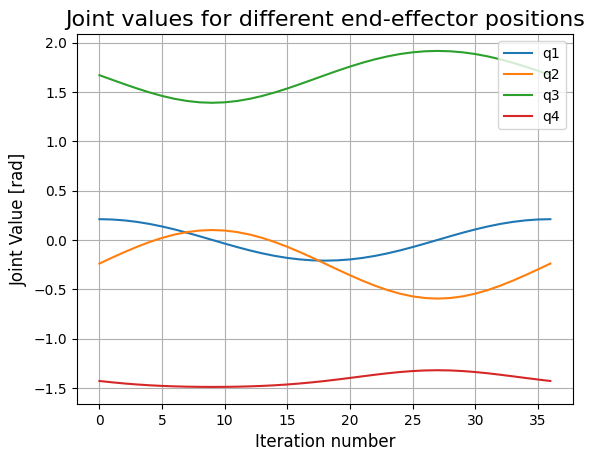

In [88]:
# P3
n = 36
psi_range = np.linspace(0, math.pi * 2, n+1)
pc = np.array([0.150, 0.0, 0.120])# -> Given
R = 0.032
# Preallocation
Q = np.zeros((len(psi_range), 4))
P = np.zeros((len(psi_range), 3))
P_FK = np.zeros((len(psi_range), 3))
Cond_num_P3 = np.zeros((len(psi_range), 1))

for i in range(n+1):
    psi = psi_range[i]
    pp4 = pc + R * np.array([0, sym.cos(psi), sym.sin(psi)])

    # Get the joint values for every point:
    q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))
    
    # Get points
    TT4_FK = T04_FK(q[0], q[1], q[2], q[3])
    p_FK = np.array([TT4_FK[0][3], TT4_FK[1][3], TT4_FK[2][3]])

    # Get Jacobian and Condition number
    J_i = get_J4(q[0], q[1], q[2], q[3])
    Cond_num_P3[i] = np.linalg.cond(J_i)

    # Save the values
    Q[i] = q
    P[i] = pp4
    P_FK[i][0] = TT4_FK[0][3]
    P_FK[i][1] = TT4_FK[1][3]
    P_FK[i][2] = TT4_FK[2][3]

# Printing
Q = np.transpose(Q)
P = np.transpose(P)
P_FK = np.transpose(P_FK)

# Checking
print(P - P_FK)

# Plotting
plt.plot(Q[0], label = 'q1')
plt.plot(Q[1], label = 'q2')
plt.plot(Q[2], label = 'q3')
plt.plot(Q[3], label = 'q4')
plt.legend()
plt.xlabel('Iteration number', fontsize = 12)
plt.ylabel('Joint Value [rad]', fontsize = 12)
plt.title('Joint values for different end-effector positions', fontsize = 16)
plt.grid(True)
plt.show()

Text(0.5, 0, 'z')

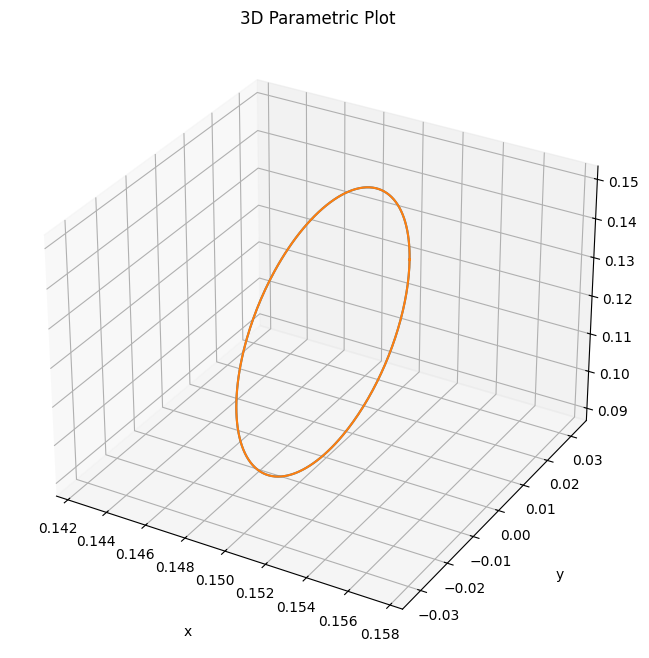

In [73]:
# FK of my Ik should give the same trajectory:


# 3D plot of the points:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
# # t = np.arange(0, 10*np.pi, np.pi/50)
# # x = np.sin(t)
# y = np.cos(t)

ax.plot3D(P[0], P[1], P[2])
ax.plot3D(P_FK[0], P_FK[1], P_FK[2])
ax.set_title('3D Parametric Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

In [21]:
# Problem 4: Determine the Jacobian of the manipulator for the robot end-effector {frame 4: This is the stylus actually} and the Jacobian for the robot camera {frame 5} (as a function of the joint configuration q). Report the numerical results for the two Jacobians at φ = 0, φ = π/2, φ = π, and φ = 3π/2 along the path studies in Problem 3.

# # Get values
o00 = np.array([0, 0, 0])
z00 = np.array([0, 0, 1]) # By default
o01 = np.array([T01[0][3], T01[1][3], T01[2][3]])
z01 = np.array([T01[0][2], T01[1][2], T01[2][2]])
o02 = np.array([T02[0][3], T02[1][3], T02[2][3]])
z02 = np.array([T02[0][2], T02[1][2], T02[2][2]])
o03 = np.array([T03[0][3], T03[1][3], T03[2][3]])
z03 = np.array([T03[0][2], T03[1][2], T03[2][2]])
o04 = np.array([T04[0][3], T04[1][3], T04[2][3]])
z04 = np.array([T04[0][2], T04[1][2], T04[2][2]])
o05 = np.array([T05[0][3], T05[1][3], T05[2][3]])
z05 = np.array([T05[0][2], T05[1][2], T05[2][2]])
#o_n = np.array([T03[0][3], T03[1][3], T03[2][3]]) # T03 is only used for the end-effector position
# Be careful in here that the z0 is always [0,0,1]' and then z0i is given by
# the T0i. NOT by T0{i+1} !!! o_i is gien by T0{i} !!!


# Get Ji
J1 = get_Ji(z00, o00, o04, joints_type[0])
J2 = get_Ji(z01, o01, o04, joints_type[1])
J3 = get_Ji(z02, o02, o04, joints_type[2])
J4 = get_Ji(z03, o03, o04, joints_type[3])

J = np.transpose(np.concatenate([[J1], [J2], [J3], [J4]]))

# Printing
print('J')
print(J)

J
[[-(0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4))*sin(th1)
  (-0.093*sin(th2) - 0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*cos(th1)
  (-0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*cos(th1)
  -0.05*sin(th2 + th3 + th4)*cos(th1)]
 [(0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4))*cos(th1)
  (-0.093*sin(th2) - 0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*sin(th1)
  (-0.093*sin(th2 + th3) - 0.05*sin(th2 + th3 + th4) + 6.93889390390723e-18)*sin(th1)
  -0.05*sin(th1)*sin(th2 + th3 + th4)]
 [0 0.093*cos(th2) + 0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4)
  0.093*cos(th2 + th3) + 0.05*cos(th2 + th3 + th4)
  0.05*cos(th2 + th3 + th4)]
 [0 1.0*sin(th1) 1.0*sin(th1) 1.0*sin(th1)]
 [0 -1.0*cos(th1) -1.0*cos(th1) -1.0*cos(th1)]
 [1 0 0 0]]


In [16]:
#Problem 4: Determine the Jacobian of the manipulator for the robot end-effector and the Jacobian for the robot camera (as a function of the joint configuration q). Report the numerical results for the two Jacobians at psi = 0, psi = π/2, psi = π, and psi = 3π/2 along the path studies in Problem 3.
# # Jacobians, using numpy (not Sympy):
# TODO: J5 !! It is the same procedure BUT I don't know if the last part covers the DH convention, so MAYBE it will not work. I have the Sympy already done.

def get_J4(th11, th22, th33, th44):
  J4 = np.array([[-(0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.sin(th11),
    (-0.093*math.sin(th22) - 0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.cos(th11), (-0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.cos(th11), -0.05*math.sin(th22 + th33 + th44)*math.cos(th11)],
  [(0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44))*math.cos(th11),
    (-0.093*math.sin(th22) - 0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.sin(th11),
    (-0.093*math.sin(th22 + th33) - 0.05*math.sin(th22 + th33 + th44))*math.sin(th11),
    -0.05*math.sin(th11)*math.sin(th22 + th33 + th44)],
  [0, 0.093*math.cos(th22) + 0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44),
    0.093*math.cos(th22 + th33) + 0.05*math.cos(th22 + th33 + th44),
    0.05*math.cos(th22 + th33 + th44)],
  [0, 1.0*math.sin(th11), 1.0*math.sin(th11), 1.0*math.sin(th11)],
  [0, -1.0*math.cos(th11), -1.0*math.cos(th11), -1.0*math.cos(th11)],
  [1, 0, 0, 0]])
  return J4

psi_index = np.array([np.where(psi_range == 0)[0][0], np.where(psi_range == math.pi/2)[0][0], np.where(psi_range == math.pi)[0][0], np.where(psi_range == 3*math.pi/2)[0][0]])
print("psi_index: ", psi_index) # This is the n iteration with the 4 desired psi values. Now I want their Jacobians (J4):

# P4
# Preallocation
J_tot_4 = []

for i in psi_index:
    psi = psi_range[i]
    pp4 = pc + R * np.array([0, sym.cos(psi), sym.sin(psi)])

    # Get the joint values for every point:
    q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))

    # Get Jacobian Matrix J4
    J_i = get_J4(q[0], q[1], q[2], q[3])

    # Save the values
    J_tot_4.append(np.around(J_i,decimals = 5))


# post-processing
#J_tot_4 = np.transpose(J_tot_4)

# Printing
print(np.array(J_tot_4))


psi_index:  [ 0  9 18 27]
[[[-0.0320 -0.0685 -0.0901 -0.0000]
  [0.1500 -0.0146 -0.0192 -0.0000]
  [0.0000 0.1534 0.0630 0.0500]
  [0.0000 0.2086 0.2086 0.2086]
  [0.0000 -0.9780 -0.9780 -0.9780]
  [1.0000 0.0000 0.0000 0.0000]]

 [[-0.0000 -0.1020 -0.0927 -0.0000]
  [0.1500 -0.0000 -0.0000 -0.0000]
  [0.0000 0.1500 0.0575 0.0500]
  [0.0000 0.0000 0.0000 0.0000]
  [0.0000 -1.0000 -1.0000 -1.0000]
  [1.0000 0.0000 0.0000 0.0000]]

 [[0.0320 -0.0685 -0.0901 -0.0000]
  [0.1500 0.0146 0.0192 0.0000]
  [0.0000 0.1534 0.0630 0.0500]
  [0.0000 -0.2086 -0.2086 -0.2086]
  [0.0000 -0.9780 -0.9780 -0.9780]
  [1.0000 0.0000 0.0000 0.0000]]

 [[0.0000 -0.0380 -0.0901 -0.0000]
  [0.1500 0.0000 0.0000 0.0000]
  [0.0000 0.1500 0.0730 0.0500]
  [0.0000 -0.0000 -0.0000 -0.0000]
  [0.0000 -1.0000 -1.0000 -1.0000]
  [1.0000 0.0000 0.0000 0.0000]]]


In [17]:
# Get the inverse velocities !! 
# For 1 J4:
J44 = J_tot_4[1]
print('J44: \n', J44)

J44_inv = np.linalg.pinv(J44)

print('J44_pinv: \n', J44_inv)
print('Rank of J4: \n',np.linalg.matrix_rank(J44))

J44: 
 [[-0.0000 -0.1020 -0.0927 -0.0000]
 [0.1500 -0.0000 -0.0000 -0.0000]
 [0.0000 0.1500 0.0575 0.0500]
 [0.0000 0.0000 0.0000 0.0000]
 [0.0000 -1.0000 -1.0000 -1.0000]
 [1.0000 0.0000 0.0000 0.0000]]
J44_pinv: 
 [[0.0000 0.1467 0.0000 0.0000 0.0000 0.9780]
 [0.8780 -0.0000 10.8956 0.0000 0.5448 0.0000]
 [-11.7536 0.0000 -11.9886 0.0000 -0.5994 -0.0000]
 [10.8756 -0.0000 1.0931 0.0000 -0.9453 0.0000]]
Rank of J4: 
 4


In [215]:
#Problem 4: Determine the Jacobian of the manipulator for the robot end-effector and the Jacobian for the robot
#  camera (as a function of the joint configuration q). Report the numerical results for the two Jacobians 
# at psi = 0, psi = π/2, psi = π, and psi = 3π/2 along the path studies in Problem 3.
print(-0.032 * math.sin(math.pi/2))


-0.032


C:\Users\el Suave\AppData\Local\Temp\ipykernel_12988\4114107153.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  wz = wy * rz / ry
C:\Users\el Suave\AppData\Local\Temp\ipykernel_12988\4114107153.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  wx = (R * math.cos(psi) + rx * wy) / ry
C:\Users\el Suave\AppData\Local\Temp\ipykernel_12988\4114107153.py:99: RuntimeWarning: invalid value encountered in matmul
  q_dot[i] = np.matmul(np.linalg.pinv(J_i), xi[i])


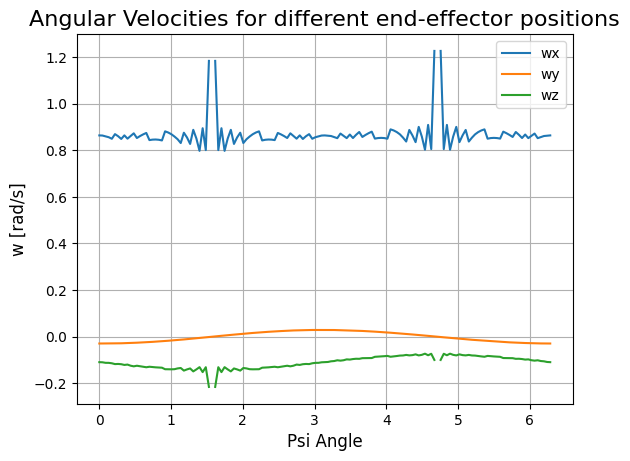

In [22]:
# Problem 5: Compute the joint velocities q˙ at psi = π/2, along the path from Problem 3, so that the stylus tip 
# velocity is v04 = [0,−3, 0]mm/s and dx4 = [?, ?, 0].
# Hint: the last quantity dx4, you have not seen it as such in the course before, so you need to think about how to 
# interpret it in terms of angular velocities.

'''def get_w_xyz(Rxx, Ryx, rx, ry, rz, R, psi):
    wx = -0.032 / ((rz/ry) * (Ryx/Rxx) * rx - rz)
    wy = (Ryx/Rxx) * wx
    wz = (rz/ry) * (Ryx/Rxx) * wx

    return wx, wy, wz'''
def get_w_xyz(rx, ry, rz, R, psi):
    wy = ((R * math.cos(psi) * rz) - (ry * R * math.sin(psi))) / (rx * (rz - 1))
    wz = wy * rz / ry
    wx = (R * math.cos(psi) + rx * wy) / ry

    return wx, wy, wz

def get_v_xyz(R, psi):
    vx = 0
    vy = - R * math.sin(psi)
    vz = R * math.cos(psi)

    return vx, vy, vz

v = np.array([0, -0.003, 0])

'''psi = psi_range[18] # pi/2
pp4 = pc + R * np.array([0, sym.cos(psi), sym.sin(psi)])

# Get the joint values for every point:
q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))

# Get FK:
TT4_FK = np.around(T04_FK(q[0], q[1], q[2], q[3]), decimals = 3)
Rxx = TT4_FK[0][0]
Ryx = TT4_FK[1][0]
ox = TT4_FK[0][3]
oy = TT4_FK[1][3]
oz = TT4_FK[2][3]

print(TT4_FK)
print(Rxx, Ryx, ox, oy, oz)
print('---')
print((oz/oy) * (Ryx/Rxx) * ox - oz)
#print( -3 / ((oz/oy) * (Ryx/Rxx) * ox - oz))
print('---')
# Get Jacobian Matrix J4
J_i = get_J4(q[0], q[1], q[2], q[3])

wx, wy, wz = get_w_xyz(Rxx, Ryx, ox, oy, oz)
v_inertial = np.array([v[0], v[1], v[2], wx, wy, wz])
print(np.around(v_inertial, decimals = 4))'''

############
n = 36 * 4
psi_range = np.linspace(0, math.pi * 2, n+1)
pc = np.array([0.150, 0.0, 0.120])# -> Given
R = 0.032
# Preallocation
J_tot = []
wx_tot = np.zeros((len(psi_range), 1))
wy_tot = np.zeros((len(psi_range), 1))
wz_tot = np.zeros((len(psi_range), 1))
vx_tot = np.zeros((len(psi_range), 1))
vy_tot = np.zeros((len(psi_range), 1))
vz_tot = np.zeros((len(psi_range), 1))
xi = np.zeros((len(psi_range), 6))
q_dot = np.zeros((len(psi_range), 4))

for i in range(n+1):
    psi = psi_range[i]
    pp4 = pc + R * np.array([0, sym.cos(psi), sym.sin(psi)])

    # Get the joint values for every point:
    q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))
    
    # Get FK
    TT4_FK = np.around(T04_FK(q[0], q[1], q[2], q[3]), decimals = 3)
    Rxx = TT4_FK[0][0]
    Ryx = TT4_FK[1][0]
    ox = TT4_FK[0][3]
    oy = TT4_FK[1][3]
    oz = TT4_FK[2][3]
    
    # Get Jacobian
    J_i = get_J4(q[0], q[1], q[2], q[3])

    # Save the values
    vx_tot[i], vy_tot[i], vz_tot[i] = get_v_xyz(R, psi)
    wx_tot[i], wy_tot[i], wz_tot[i] = get_w_xyz(ox, oy, oz, R, psi)

    xi[i] = np.concatenate([vx_tot[i], vy_tot[i], vz_tot[i], wx_tot[i], wy_tot[i], wz_tot[i]])
    '''print(rrr)
    print(xi[i])
    xi[i] = rrr'''

    # Calculate the q_dot_values
    q_dot[i] = np.matmul(np.linalg.pinv(J_i), xi[i])

    J_tot_4.append(np.around(J_i,decimals = 5))
    

###########
# Plotting
plt.plot(psi_range, wx_tot, label = 'wx')
plt.plot(psi_range, wy_tot, label = 'wy')
plt.plot(psi_range, wz_tot, label = 'wz')
plt.legend()
plt.xlabel('Psi Angle', fontsize = 12)
plt.ylabel('w [rad/s]', fontsize = 12)
# plt.ylim(-250, 250)
plt.grid(True)
plt.title('Angular Velocities for different end-effector positions', fontsize = 16)
plt.show()

In [23]:
pp4 = pc + R * np.array([0, sym.cos(math.pi/2), sym.sin(math.pi/2)])

# Get the joint values for every point:
q = np.array(get_joints(pp4, l1, l2, l3, l4,"elbow-up", 0))

# Get FK
TT4_FK = np.around(T04_FK(q[0], q[1], q[2], q[3]), decimals = 3)
Rxx = TT4_FK[0][0]
Ryx = TT4_FK[1][0]
ox = TT4_FK[0][3]
oy = TT4_FK[1][3]
oz = TT4_FK[2][3]

# Get Jacobian
J_i = get_J4(q[0], q[1], q[2], q[3])

# Save the values
vx = 0
vy = -0.03
vz = 0
wx = vy/oz
wy = 0
wz = vy/ox

xi = np.array([vx, vy, vz, wx, wy, wz])
q_dot = np.matmul(np.linalg.pinv(J_i), xi)

print(np.around(q_dot, decimals = 3))

[-0.2000 0.0000 -0.0000 0.0000]


![alt text](P5_x_dot.png "Title")

#########################################
# TRAJECTORY PLANNING #
#########################################

![alt text](trajectory01.png "Title")

[0.0000 0.0002 0.0019 0.0062 0.0144 0.0273 0.0459 0.0707 0.1024 0.1412
 0.1875 0.2412 0.3024 0.3707 0.4459 0.5273 0.6144 0.7062 0.8019 0.9002
 1.0000]
[0.0000 0.0073 0.0280 0.0608 0.1040 0.1562 0.2160 0.2818 0.3520 0.4253
 0.5000 0.5748 0.6480 0.7183 0.7840 0.8438 0.8960 0.9393 0.9720 0.9928
 1.0000]
[0.0000 0.1425 0.2700 0.3825 0.4800 0.5625 0.6300 0.6825 0.7200 0.7425
 0.7500 0.7425 0.7200 0.6825 0.6300 0.5625 0.4800 0.3825 0.2700 0.1425
 0.0000]


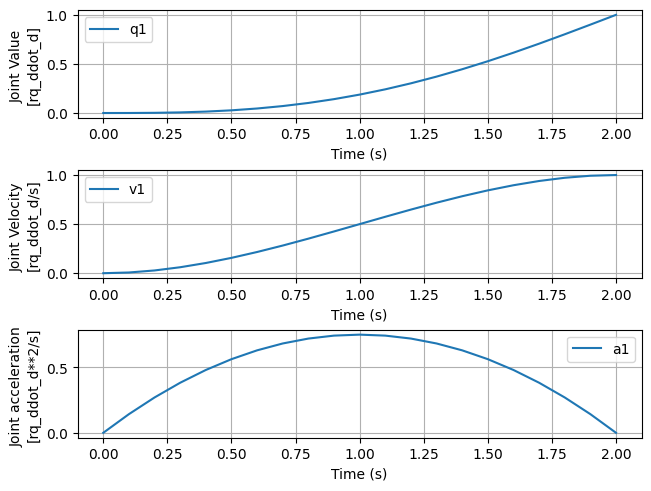

In [18]:
# This works for one segment:
# I need to get the real joint velocities from the velocities given

def get_quintic_coeff(q0,v0,ac0,q1,v1,ac1,t0,tf, time_steps):
    
    t = np.linspace(t0, tf, time_steps+1)
    
    M = np.array([
        [1, t0, t0 ** 2, t0 ** 3, t0 ** 4, t0 ** 5],
        [0, 1, 2*t0, 3*t0 ** 2, 4*t0 ** 3, 5*t0 ** 4],
        [0, 0, 2, 6*t0, 12*t0 ** 2, 20*t0 ** 3],
        [1, tf, tf ** 2, tf ** 3, tf ** 4, tf ** 5],
        [0, 1, 2 * tf, 3*tf ** 2, 4*tf ** 3, 5*tf ** 4],
        [0, 0, 2, 6*tf, 12*tf**2, 20*tf**3]])
    
    #print('M: \n', M)
    b= np.transpose([q0, v0, ac0, q1, v1, ac1])
    #print('b: \n', b)
    a = np.matmul(np.linalg.pinv(M), b)
    a = np.round(a, decimals=8)
    #print('a: \n', a)

    # Use of it
    q_d = a[0] + a[1] *t +a[2] *t ** 2 + a[3] *t ** 3 +a[4]*t ** 4 + a[5] *t ** 5 # position trajectory
    q_dot_d = a[1] + 2 * a[2] * t + 3 *a[3] * t ** 2 + 4 * a[4] * t ** 3 + 5 * a[5] * t ** 4 #  velocity trajectory
    q_ddot_d = 2 * a[2] + 6 * a[3] * t + 12 * a[4] * t ** 2 + 20 * a[5] * t ** 3 #  acceleration trajectory

    return q_d, q_dot_d, q_ddot_d, t

# Input data:
q0   = 0
q_dot0   = 0
q_ddot0  = 0
qf   = 1
q_dotf   = 1
q_ddotf  = 0
t0   = 0
tf   = 2
time_steps = 20

# Calculation
q_d, q_dot_d, q_ddot_d, t = get_quintic_coeff(q0, q_dot0, q_ddot0, qf, q_dotf, q_ddotf, t0, tf, time_steps)

# Printing -> Checking:

print(q_d)
print(q_dot_d)
print(q_ddot_d)

# Graphs:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout='constrained')
ax1.plot(t, q_d, label = 'q1')
ax1.legend()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Joint Value \n[rq_ddot_d]')
ax1.grid(True)

ax2.plot(t, q_dot_d, label = 'v1')
ax2.legend()
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Joint Velocity \n[rq_ddot_d/s]')
ax2.grid(True)

ax3.plot(t, q_ddot_d, label = 'a1')
ax3.legend()
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Joint acceleration \n[rq_ddot_d**2/s]')
ax3.grid(True)
plt.show()


#######################################################
#######################################################

In [ ]:
QQ = np.transpose(Q)
print(QQ.shape)
k = 8
Q_dot_0 = QQ[0] - QQ[1]
n = 9 * k
Q_dot_pi_2 = QQ[n-1] - QQ[n]
n = 18 * k
Q_dot_pi = QQ[n-1] - QQ[n]
n = 27 * k
Q_dot_3pi_2 = QQ[n-1] - QQ[n]
n = 36 * k
Q_dot_2pi = QQ[n-1] - QQ[n]
print('Q_dot in t=0: \n', Q_dot_0)
print('Q_dot in t=2: \n', Q_dot_pi_2)
print('Q_dot in t=4: \n', Q_dot_pi)
print('Q_dot in t=6: \n', Q_dot_3pi_2)
print('Q_dot in t=8: \n', Q_dot_2pi)
print(0.0047/0.0001)

(289, 4)
288
Q_dot in t=0: 
 [0.0000 -0.0075 0.0057 0.0018]
Q_dot in t=2: 
 [0.0047 -0.0001 0.0001 0.0000]
Q_dot in t=4: 
 [0.0000 0.0075 -0.0057 -0.0018]
Q_dot in t=6: 
 [-0.0047 0.0001 -0.0001 -0.0000]
Q_dot in t=8: 
 [-0.0000 -0.0075 0.0057 0.0018]
47.0


#######################################################
#######################################################

In [94]:
# I have 4 segments, so I will do 4 solutions of the segment:
# I need:
# q0, q_dot0, q_ddot0, qf, q_dotf, q_ddotf, t0, tf, time_steps 
# for EACH segment -> I will collapse all into one array.

# Given data:
ta0 = 0
taf = 2
tb0 = 0
tbf = 2
tc0 = 0
tcf = 2
td0 = 0
tdf = 2

q_ddot0 = 0
q_ddotf = 0

v_mod = 0.03 #0.027

v_ta0 = np.array([0, 0, 0])
v_taf = np.array([0, -v_mod, 0])
v_tb0 = v_taf
v_tbf = np.array([0, 0, -v_mod])
v_tc0 = v_tbf
v_tcf = np.array([0, v_mod, 0])
v_td0 = v_tcf
v_tdf = np.array([0, 0, 0])

# Get Joint Values at limits:
q_ta0 = np.array(get_joints(pc + R * np.array([0, sym.cos(psi_range[0]), sym.sin(psi_range[0])]), l1, l2, l3, l4,"elbow-up", 0))
q_taf = np.array(get_joints(pc + R * np.array([0, sym.cos(psi_range[9]), sym.sin(psi_range[9])]), l1, l2, l3, l4,"elbow-up", 0))
q_tb0 = q_taf
q_tbf = np.array(get_joints(pc + R * np.array([0, sym.cos(psi_range[18]), sym.sin(psi_range[18])]), l1, l2, l3, l4,"elbow-up", 0))
q_tc0 = q_tbf
q_tcf = np.array(get_joints(pc + R * np.array([0, sym.cos(psi_range[27]), sym.sin(psi_range[27])]), l1, l2, l3, l4,"elbow-up", 0))
q_td0 = q_tcf
q_tdf = np.array(get_joints(pc + R * np.array([0, sym.cos(psi_range[36]), sym.sin(psi_range[36])]), l1, l2, l3, l4,"elbow-up", 0))


# Get the joint velocities from the inertial velocity:
# FK
T4_ta0 = np.around(T04_FK(q_ta0[0], q_ta0[1], q_ta0[2], q_ta0[3]), decimals = 7)
T4_taf = np.around(T04_FK(q_taf[0], q_taf[1], q_taf[2], q_taf[3]), decimals = 7)
T4_tbf = np.around(T04_FK(q_tbf[0], q_tbf[1], q_tbf[2], q_tbf[3]), decimals = 7)
T4_tcf = np.around(T04_FK(q_tcf[0], q_tcf[1], q_tcf[2], q_tcf[3]), decimals = 7)
T4_tdf = np.around(T04_FK(q_tdf[0], q_tdf[1], q_tdf[2], q_tdf[3]), decimals = 7)

# Angular velocities:
# SFor point A0
wx_a0 = 0
wy_a0 = 0
wz_a0 = 0

wx_af = v_taf[1]/T4_taf[2][3]
wy_af = 0
wz_af = v_taf[1]/T4_taf[0][3]

wx_bf = v_tbf[2]/T4_tbf[1][3]
wy_bf = v_tbf[2]/T4_tbf[0][3]
wz_bf = 0

wx_cf = v_tcf[1]/T4_tcf[2][3]
wy_cf = 0
wz_cf = v_tcf[1]/T4_tcf[0][3]

wx_df = 0
wy_df = 0
wz_df = 0

xi_a0 = np.array([v_ta0[0], v_ta0[1], v_ta0[2], wx_a0, wy_a0, wz_a0])
xi_af = np.array([v_taf[0], v_taf[1], v_taf[2], wx_af, wy_af, wz_af])
xi_bf = np.array([v_tbf[0], v_tbf[1], v_tbf[2], wx_bf, wy_bf, wz_bf])
xi_cf = np.array([v_tcf[0], v_tcf[1], v_tcf[2], wx_cf, wy_cf, wz_cf])
xi_df = np.array([v_tdf[0], v_tdf[1], v_tdf[2], wx_df, wy_df, wz_df])
# Missing the following ones

# Get Jacobian
Ja0 = get_J4(q_ta0[0], q_ta0[1], q_ta0[2], q_ta0[3])
Jaf = get_J4(q_taf[0], q_taf[1], q_taf[2], q_taf[3])
Jbf = get_J4(q_tbf[0], q_tbf[1], q_tbf[2], q_tbf[3])
Jcf = get_J4(q_tcf[0], q_tcf[1], q_tcf[2], q_tcf[3])
Jdf = get_J4(q_tdf[0], q_tdf[1], q_tdf[2], q_tdf[3])

q_dot_a0 = np.matmul(np.linalg.pinv(Ja0), xi_a0)
q_dot_af = np.matmul(np.linalg.pinv(Jaf), xi_af)
q_dot_bf = np.matmul(np.linalg.pinv(Jbf), xi_bf)
q_dot_cf = np.matmul(np.linalg.pinv(Jcf), xi_cf)
q_dot_df = np.matmul(np.linalg.pinv(Jdf), xi_df)

#print(np.around(q_dot, decimals = 3))
print('q_dot_a0: \n', np.around(q_dot_a0,decimals = 6))
print('q_dot_af: \n', np.around(q_dot_af,decimals = 6))
print('q_dot_bf: \n', np.around(q_dot_bf,decimals = 6))
'''
print('q_dot_cf: \n', np.around(q_dot_cf,decimals = 6))
print('q_dot_df: \n', np.around(q_dot_df,decimals = 6))'''
'''Q_dot in t=0: 
 [0.0000 -0.0075 0.0057 0.0018]
Q_dot in t=2: 
 [0.0047 -0.0001 0.0001 0.0000]
Q_dot in t=4: 
 [0.0000 0.0075 -0.0057 -0.0018]
Q_dot in t=6: 
 [-0.0047 0.0001 -0.0001 -0.0000]
Q_dot in t=8: 
 [-0.0000 -0.0075 0.0057 0.0018]'''
'''print('---')
q_bis_af = np.array([-0.1998, 0, 0, 0])
print('Usando mi q_dot_numerico: \n', np.matmul(Ja0, q_bis_af))
q_dot_a0_bis = np.matmul(np.linalg.pinv(Ja0), np.array([0, -v_mod, 0, 0, 0, 0]))
print('q_dot_a0_bis',q_dot_a0_bis)
print('---')
print(T4_taf)'''

q_dot_a0: 
 [0.0000 0.0000 0.0000 0.0000]
q_dot_af: 
 [-0.2000 0.0000 -0.0000 0.0000]
q_dot_bf: 
 [0.0000 -0.3210 0.2440 0.0770]


"print('---')\nq_bis_af = np.array([-0.1998, 0, 0, 0])\nprint('Usando mi q_dot_numerico: \n', np.matmul(Ja0, q_bis_af))\nq_dot_a0_bis = np.matmul(np.linalg.pinv(Ja0), np.array([0, -v_mod, 0, 0, 0, 0]))\nprint('q_dot_a0_bis',q_dot_a0_bis)\nprint('---')\nprint(T4_taf)"

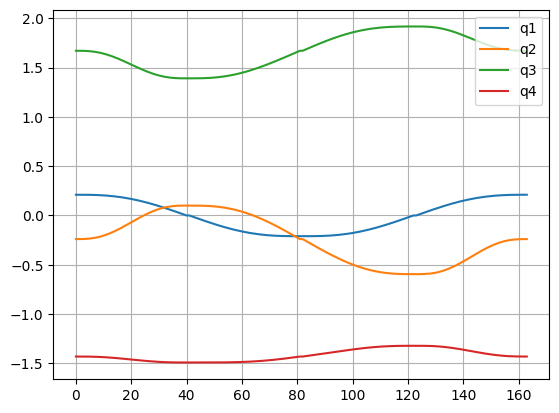

"\nfig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout='constrained')\n#fig, ax1 = plt.plot()\nax1.plot(q1, label = 'q1')\nax1.plot(q2, label = 'q2')\nax1.plot(q3, label = 'q3')\nax1.plot(q4, label = 'q4')\nax1.legend()\nax1.set_xlabel('Time (s)')\nax1.set_ylabel('Joint Value \n[rq_ddot_d]')\nax1.grid(True)\n\nax2.plot(q1_dot, label = 'v1')\nax2.legend()\nax2.set_xlabel('Time (s)')\nax2.set_ylabel('Joint Velocity \n[rq_ddot_d/s]')\nax2.grid(True)\n\nax3.plot(q1_ddot, label = 'a1')\nax3.legend()\nax3.set_xlabel('Time (s)')\nax3.set_ylabel('Joint acceleration \n[rq_ddot_d**2/s]')\nax3.grid(True)\nplt.show()"

In [ ]:
# Calculation

time_steps = 40

for i in range(4): # Make the trajectories
    q_dA, q_dot_dA, q_ddot_dA, tA = get_quintic_coeff(q_ta0[i], q_dot_a0[i], q_ddot0, q_taf[i], q_dot_af[i], q_ddot0, ta0, taf, time_steps)
    q_dB, q_dot_dB, q_ddot_dB, tB = get_quintic_coeff(q_taf[i], q_dot_af[i], q_ddot0, q_tbf[i], q_dot_bf[i], q_ddot0, tb0, tbf, time_steps)
    q_dC, q_dot_dC, q_ddot_dC, tC = get_quintic_coeff(q_tbf[i], q_dot_bf[i], q_ddot0, q_tcf[i], q_dot_cf[i], q_ddot0, tc0, tcf, time_steps)
    q_dD, q_dot_dD, q_ddot_dD, tD = get_quintic_coeff(q_tcf[i], q_dot_cf[i], q_ddot0, q_tdf[i], q_dot_df[i], q_ddot0, td0, tdf, time_steps)

    if i ==0:
        q1 = np.concatenate((q_dA, q_dB, q_dC, q_dD), axis = None)
        q1_dot = np.concatenate((q_dot_dA, q_dot_dB, q_dot_dC, q_dot_dD), axis = None)
        q1_ddot = np.concatenate((q_ddot_dA, q_ddot_dB, q_ddot_dC, q_ddot_dD), axis = None)
    if i ==1:
        q2 = np.concatenate((q_dA, q_dB, q_dC, q_dD), axis = None)
        q2_dot = np.concatenate((q_dot_dA, q_dot_dB, q_dot_dC, q_dot_dD), axis = None)
        q2_ddot = np.concatenate((q_ddot_dA, q_ddot_dB, q_ddot_dC, q_ddot_dD), axis = None)
    if i ==2:
        q3 = np.concatenate((q_dA, q_dB, q_dC, q_dD), axis = None)
        q3_dot = np.concatenate((q_dot_dA, q_dot_dB, q_dot_dC, q_dot_dD), axis = None)
        q3_ddot = np.concatenate((q_ddot_dA, q_ddot_dB, q_ddot_dC, q_ddot_dD), axis = None)
    if i ==3:
        q4 = np.concatenate((q_dA, q_dB, q_dC, q_dD), axis = None)
        q4_dot = np.concatenate((q_dot_dA, q_dot_dB, q_dot_dC, q_dot_dD), axis = None)
        q4_ddot = np.concatenate((q_ddot_dA, q_ddot_dB, q_ddot_dC, q_ddot_dD), axis = None)


# Condition number
Cond_num_P6 = np.zeros((len(q1), 1))
for i in range(len(q1)):
    # Get Jacobian and Condition number
    J_i = get_J4(q1[i], q2[i], q3[i], q4[i])
    Cond_num_P6[i] = np.linalg.cond(J_i)

# Plotting
plt.plot(q1, label = 'q1')
plt.plot(q2, label = 'q2')
plt.plot(q3, label = 'q3')
plt.plot(q4, label = 'q4')
plt.legend()
plt.grid(True)
plt.show()
'''
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout='constrained')
#fig, ax1 = plt.plot()
ax1.plot(q1, label = 'q1')
ax1.plot(q2, label = 'q2')
ax1.plot(q3, label = 'q3')
ax1.plot(q4, label = 'q4')
ax1.legend()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Joint Value \n[rq_ddot_d]')
ax1.grid(True)

ax2.plot(q1_dot, label = 'v1')
ax2.legend()
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Joint Velocity \n[rq_ddot_d/s]')
ax2.grid(True)

ax3.plot(q1_ddot, label = 'a1')
ax3.legend()
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Joint acceleration \n[rq_ddot_d**2/s]')
ax3.grid(True)
plt.show()'''

Text(0.5, 0, 'z')

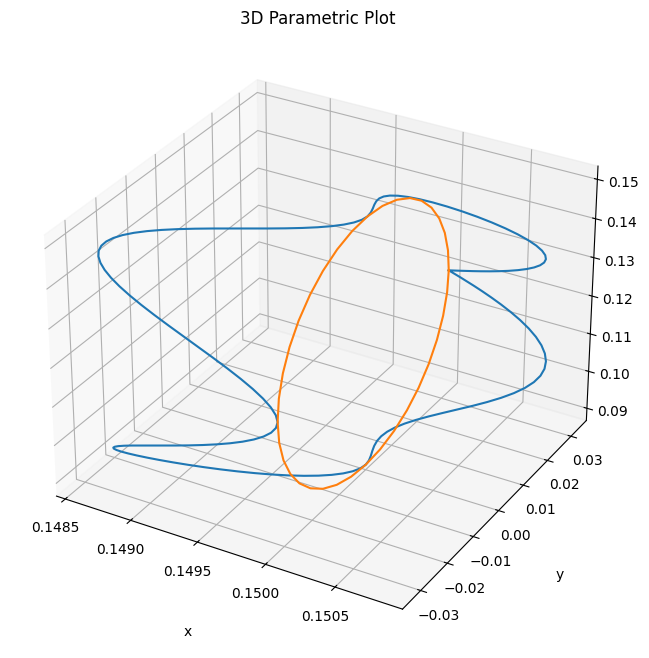

In [ ]:
PP_FK = np.zeros((len(q1), 3))
# For the trajectory part
for i in range(len(q1)):
    TT4_FK = T04_FK(q1[i], q2[i], q3[i], q4[i])
    
    # Save the values
    PP_FK[i][0] = TT4_FK[0][3]
    PP_FK[i][1] = TT4_FK[1][3]
    PP_FK[i][2] = TT4_FK[2][3]

PP_FK = np.transpose(PP_FK)

# 3D plot of the points:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()

#ax.plot3D(PP_FK[0][0:len(q_dA)], PP_FK[1][0:len(q_dA)], PP_FK[2][0:len(q_dA)])
ax.plot3D(PP_FK[0], PP_FK[1], PP_FK[2])
ax.plot3D(P[0], P[1], P[2])
ax.set_title('3D Parametric Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
# ax.view_init(elev=90, azim=-90, roll=0) # -> De arriba (XY)
# ax.view_init(elev=0, azim=0, roll=0) # -> De costado (ZY) - el circulo
# ax.view_init(elev=0, azim=-90, roll=0) # -> De costado (XZ)

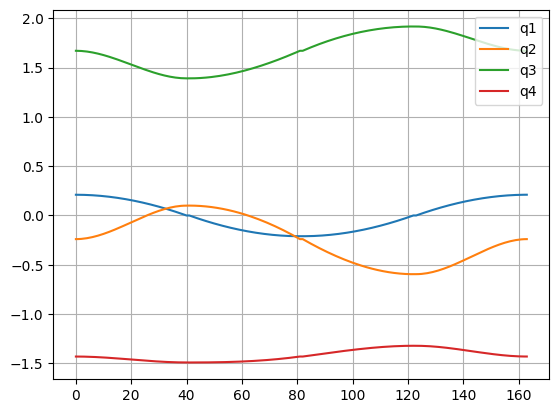

"ax2.plot(q1_dot, label = 'v1')\nax2.legend()\nax2.set_xlabel('Time (s)')\nax2.set_ylabel('Joint Velocity \n[rq_ddot_d/s]')\nax2.grid(True)\n\nax3.plot(q1_ddot, label = 'a1')\nax3.legend()\nax3.set_xlabel('Time (s)')\nax3.set_ylabel('Joint acceleration \n[rq_ddot_d**2/s]')\nax3.grid(True)\nplt.show()"

In [114]:
# I will try the same with a cubic function:
# The problem may lie in the accelerations:


time_steps = 40

for i in range(4):
    q_dA, q_dot_dA, q_ddot_dA, tA = get_cubic_coeff(q_ta0[i], q_dot_a0[i], q_taf[i], q_dot_af[i], ta0, taf, time_steps)
    q_dB, q_dot_dB, q_ddot_dB, tB = get_cubic_coeff(q_taf[i], q_dot_af[i], q_tbf[i], q_dot_bf[i], tb0, tbf, time_steps)
    q_dC, q_dot_dC, q_ddot_dC, tC = get_cubic_coeff(q_tbf[i], q_dot_bf[i], q_tcf[i], q_dot_cf[i], tc0, tcf, time_steps)
    q_dD, q_dot_dD, q_ddot_dD, tD = get_cubic_coeff(q_tcf[i], q_dot_cf[i], q_tdf[i], q_dot_df[i], td0, tdf, time_steps)

    if i ==0:
        q1 = np.concatenate((q_dA, q_dB, q_dC, q_dD), axis = None)
        q1_dot = np.concatenate((q_dot_dA, q_dot_dB, q_dot_dC, q_dot_dD), axis = None)
        q1_ddot = np.concatenate((q_ddot_dA, q_ddot_dB, q_ddot_dC, q_ddot_dD), axis = None)
    if i ==1:
        q2 = np.concatenate((q_dA, q_dB, q_dC, q_dD), axis = None)
        q2_dot = np.concatenate((q_dot_dA, q_dot_dB, q_dot_dC, q_dot_dD), axis = None)
        q2_ddot = np.concatenate((q_ddot_dA, q_ddot_dB, q_ddot_dC, q_ddot_dD), axis = None)
    if i ==2:
        q3 = np.concatenate((q_dA, q_dB, q_dC, q_dD), axis = None)
        q3_dot = np.concatenate((q_dot_dA, q_dot_dB, q_dot_dC, q_dot_dD), axis = None)
        q3_ddot = np.concatenate((q_ddot_dA, q_ddot_dB, q_ddot_dC, q_ddot_dD), axis = None)
    if i ==3:
        q4 = np.concatenate((q_dA, q_dB, q_dC, q_dD), axis = None)
        q4_dot = np.concatenate((q_dot_dA, q_dot_dB, q_dot_dC, q_dot_dD), axis = None)
        q4_ddot = np.concatenate((q_ddot_dA, q_ddot_dB, q_ddot_dC, q_ddot_dD), axis = None)
'''q1 = np.concatenate((q_dA, q_dB, q_dC, q_dD), axis = None)
q1_dot = np.concatenate((q_dot_dA, q_dot_dB, q_dot_dC, q_dot_dD), axis = None)
q1_ddot = np.concatenate((q_ddot_dA, q_ddot_dB, q_ddot_dC, q_ddot_dD), axis = None)'''
# Plotting
# Graphs:
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout='constrained')
#fig, ax1 = plt.plot()
plt.plot(q1, label = 'q1')
plt.plot(q2, label = 'q2')
plt.plot(q3, label = 'q3')
plt.plot(q4, label = 'q4')
plt.legend()
'''plt.set_xlabel('Time (s)')
plt.set_ylabel('Joint Value \n[rq_ddot_d]')'''
plt.grid(True)
plt.show()
'''ax2.plot(q1_dot, label = 'v1')
ax2.legend()
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Joint Velocity \n[rq_ddot_d/s]')
ax2.grid(True)

ax3.plot(q1_ddot, label = 'a1')
ax3.legend()
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Joint acceleration \n[rq_ddot_d**2/s]')
ax3.grid(True)
plt.show()'''



Text(0.5, 0, 'z')

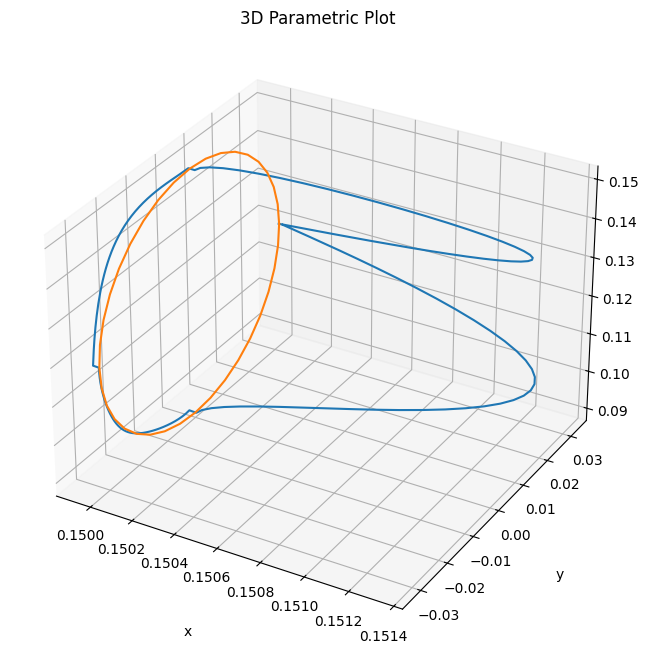

In [395]:
PP_FK = np.zeros((len(q1), 3))
# For the trajectory part
for i in range(len(q1)):
    TT4_FK = T04_FK(q1[i], q2[i], q3[i], q4[i])
    
    # Save the values
    PP_FK[i][0] = TT4_FK[0][3]
    PP_FK[i][1] = TT4_FK[1][3]
    PP_FK[i][2] = TT4_FK[2][3]

PP_FK = np.transpose(PP_FK)

#print(PP_FK)
# 3D plot of the points:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
# # t = np.arange(0, 10*np.pi, np.pi/50)
# # x = np.sin(t)
# y = np.cos(t)

ax.plot3D(PP_FK[0], PP_FK[1], PP_FK[2])
ax.plot3D(P[0], P[1], P[2])
ax.set_title('3D Parametric Plot')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

#########################################
# SINGULARITIES AND STATICS #
#########################################

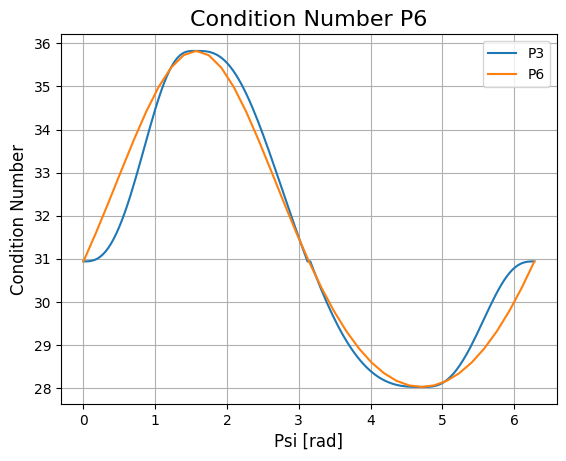

In [115]:
# P8: Plot Condition number
# Problem 8: Plot the condition number of the Jacobian matrix of the manipulator along the path from Problem 3 as well as along the actual path from Problem 6 or 7, and evaluate if the path includes any singularities. 
# Hint: The condition number of a matrix is the ratio of the largest to the smallest eigenvalue. The larger the value the closest the matrix to being singular. You can use the ”cond” function in Matlab or ”numpy.linalg.cond” in Python.

psi_range_P6 = np.linspace(0, math.pi * 2, len(q1))
plt.plot(psi_range_P6, Cond_num_P6, label = 'P3')
plt.plot(psi_range, Cond_num_P3, label = 'P6')
plt.xlabel('Psi [rad]', fontsize = 12)
plt.ylabel('Condition Number', fontsize = 12)
plt.title('Condition Number P6', fontsize = 16)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# P9: Torque calculation
# # Problem 9: Neglecting the own mass of the robot arm, and assuming a weight of 1 N acting on the end-effector along the negative z0 direction, calculate and plot all joint torques (tau1, tau2, tau3, tau4) as a function of the position psi in [0, 2pi]. 
# Hint: Neglect friction and other losses